In [1]:
from nlp import load_dataset, Dataset
import pandas as pd
import re
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast
from datasets import load_metric
import numpy as np
from torch.nn import Softmax
from torch.utils.data import DataLoader
from torch import argmax


In [2]:
# read in our cleaned tweet from the model_serving notebook
tweets = pd.read_csv('../data/cleaned_tweets.csv', encoding='ISO-8859-1')

# convert the date to a datetime format
tweets['date'] = pd.to_datetime(tweets['TweetAt']).astype('datetime64[ms]')

# set our index as our datetime column and delete the date columns
tweets.index = tweets['date']
del tweets['date']

# Sort our tweets
tweets.sort_index(inplace=True)

tweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,label
date,,,,,,,,,
2020-01-04,29309,74261,"Tidal County, Knoxville, TN",01-04-2020,Overwhelmed with info Before you act stop Ask ...,Positive,1,Overwhelmed with info Before you act stop Ask ...,2
2020-01-04,29316,74268,"Fort George G. Meade, Md.",01-04-2020,Malwarebytes rounded up some useful tips for s...,Extremely Positive,1,Malwarebytes rounded up some useful tips for s...,2
2020-01-04,29317,74269,Australia,01-04-2020,A Queensland mum has posted a heartbreaking pi...,Extremely Negative,1,A Queensland mum has posted a heartbreaking pi...,0
2020-01-04,29318,74270,Debt Jubilee,01-04-2020,New President Trump says U S gasoline prices w...,Neutral,1,New President Trump says U S gasoline prices w...,1
2020-01-04,29319,74271,??to Miami,01-04-2020,SUPERMARKET SAFETY is the latest grocery chain...,Extremely Positive,1,SUPERMARKET SAFETY is the latest grocery chain...,2


<AxesSubplot:>

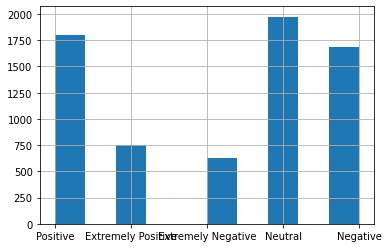

In [3]:
tweets['Sentiment'].hist()

<AxesSubplot:>

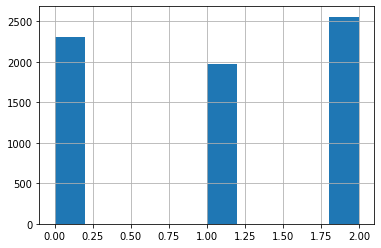

In [4]:
tweets['label'].hist()

<AxesSubplot:>

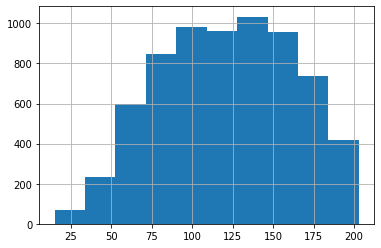

In [5]:
tweets['text'].apply(len).hist()

<AxesSubplot:xlabel='date'>

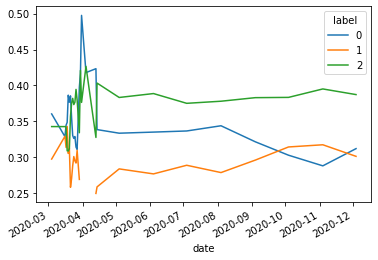

In [6]:
tweets.groupby('date')['label'].value_counts(normalize=True).unstack().rolling(3).mean().plot()

## Grab tweets up until the end of March

In [7]:
training_tweets = tweets[:'2020-03'].reset_index()
training_tweets.tail()


,date,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,label
2152,2020-03-31,29063,74015,"Toronto, Canada",31-03-2020,Saputo says demand for its products is shiftin...,Negative,3,Saputo says demand for its products is shiftin...,0
2153,2020-03-31,28994,73946,"has passport, will travel",31-03-2020,Covid 19 - milk supply under threat amid deman...,Negative,3,Covid 19 - milk supply under threat amid deman...,0
2154,2020-03-31,29204,74156,"Walhalla, South Carolina",31-03-2020,Our latest details how fraudsters are trying t...,Negative,3,Our latest details how fraudsters are trying t...,0
2155,2020-03-31,29187,74139,"Arlington, VA",31-03-2020,Some consumer companies tap nearly 99B amid bo...,Neutral,3,Some consumer companies tap nearly 99B amid bo...,1
2156,2020-03-31,29276,74228,"Geneva, Switzerland",31-03-2020,EuropeÃÂs fresh food supply is being threate...,Negative,3,EuropeÃÂs fresh food supply is being threate...,0


In [8]:
tweet_dataset = Dataset.from_pandas(training_tweets[['text', 'label']])

# Dataset has a built in train test split method
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
BERT_MODEL = 'distilbert-base-uncased'
bert_tokenizer = DistilBertTokenizerFast.from_pretrained(BERT_MODEL)

In [10]:
# We will pad our dataset so that our input matrices are the same length and truncate
def preprocess(data):
    return bert_tokenizer(data['text'], padding=True, truncation=True, max_length=128)

train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Ignored unknown kwarg option direction


  0%|          | 0/1 [00:00<?, ?it/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


  0%|          | 0/1 [00:00<?, ?it/s]

Ignored unknown kwarg option direction


In [11]:
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=3,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

In [12]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [13]:
len(train_set)

1725

## Train a model on Tweets until the end of March

In [14]:
batch_size = 32
epochs = 2

training_args = TrainingArguments(
    output_dir='./drift_clf/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./drift_clf/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

# Define the trainer
trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics
)

In [15]:
URL_REGEX = re.compile('http(s)?:\/\/t.co\/\w+')
MENTION_REGEX = re.compile('@\w+')
def clean_tweet(tweet):
    # remove mentions, the pound sign, and replace urls with URL token
    tweet = re.sub(URL_REGEX, 'url', tweet)  # replace urls with url. Assumes that the mention of a url is significant
    tweet = re.sub(MENTION_REGEX, '', tweet)  # remove mentions entirely
    tweet = tweet.replace('#', '')  # remove pound signs
    
    return tweet.strip()

In [16]:
Softmax(dim=1)(sequence_classification_model(
    bert_tokenizer.encode(clean_tweet('Corona Virus sucks so bad'), return_tensors='pt')).logits)

tensor([[0.3465, 0.3342, 0.3193]], grad_fn=<SoftmaxBackward0>)

In [17]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 432
  Batch size = 32


{'eval_loss': 1.0979571342468262,
 'eval_accuracy': 0.33101851851851855,
 'eval_runtime': 4.5475,
 'eval_samples_per_second': 94.998,
 'eval_steps_per_second': 3.079}

## Train our DistilBERT model on tweets up until the end of March

In [18]:
trainer.train()

/opt/homebrew/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1725
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 108


Epoch,Training Loss,Validation Loss,Accuracy
1,0.960500,0.819714,0.636574
2,0.636500,0.733567,0.706019


***** Running Evaluation *****
  Num examples = 432
  Batch size = 32
Saving model checkpoint to ./drift_clf/results/checkpoint-54
Configuration saved in ./drift_clf/results/checkpoint-54/config.json
Model weights saved in ./drift_clf/results/checkpoint-54/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 432
  Batch size = 32
Saving model checkpoint to ./drift_clf/results/checkpoint-108
Configuration saved in ./drift_clf/results/checkpoint-108/config.json
Model weights saved in ./drift_clf/results/checkpoint-108/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./drift_clf/results/checkpoint-108 (score: 0.73356693983078).


TrainOutput(global_step=108, training_loss=0.7984670709680628, metrics={'train_runtime': 227.716, 'train_samples_per_second': 15.15, 'train_steps_per_second': 0.474, 'total_flos': 86583995169300.0, 'train_loss': 0.7984670709680628, 'epoch': 2.0})

In [19]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 432
  Batch size = 32


{'eval_loss': 0.73356693983078,
 'eval_accuracy': 0.7060185185185185,
 'eval_runtime': 4.6034,
 'eval_samples_per_second': 93.843,
 'eval_steps_per_second': 3.041,
 'epoch': 2.0}

In [20]:
# Our model is definitely performing better
Softmax(dim=1)(sequence_classification_model(
    bert_tokenizer.encode(clean_tweet('Corona Virus sucks so bad'), return_tensors='pt')).logits)

tensor([[0.8494, 0.0543, 0.0964]], grad_fn=<SoftmaxBackward0>)

In [21]:
# save our best model
trainer.save_model()

Saving model checkpoint to ./drift_clf/results
Configuration saved in ./drift_clf/results/config.json
Model weights saved in ./drift_clf/results/pytorch_model.bin


## Load up our fine-tuned model (in the future)

In [22]:
# Load our model from our training directory
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(
    './drift_clf/results', num_labels=3
)


loading configuration file ./drift_clf/results/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}

loading weights file ./drift_clf/results/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClas

# Predict all tweets from April 1 onwards using the model only trained up until March

In [24]:
april_onwards = tweets.loc['2020-4':].reset_index()

april_onwards = Dataset.from_pandas(april_onwards[['text', 'label']])

# We will pad our dataset so that our input matrices are the same length and truncate
def preprocess(data):
    return bert_tokenizer(data['text'], padding=True, truncation=True, max_length=128)

april_onwards = april_onwards.map(preprocess, batched=True, batch_size=len(april_onwards))

april_onwards.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

tweets['predicted_label'] = None
tweets.loc['2020-4':, 'predicted_label'] = trainer.predict(april_onwards).predictions.argmax(1)

Ignored unknown kwarg option direction


  0%|          | 0/1 [00:00<?, ?it/s]

Ignored unknown kwarg option direction


***** Running Prediction *****
  Num examples = 4685
  Batch size = 32


In [25]:
tweets.tail(2)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,label,predicted_label
date,,,,,,,,,,
2020-12-04,42574,87526,Berlin,12-04-2020,Confronting shows how far a infected person s...,Positive,12,Confronting shows how far a infected person s ...,2,0
2020-12-04,42989,87941,"Boston, MA",12-04-2020,Via @Forrester Navigate To The New Norm: Insig...,Neutral,12,Via Navigate To The New Norm: Insights From F...,1,1


In [27]:
tweets['correct_label'] = tweets['predicted_label'] == tweets['label']

tweets.groupby('month')['correct_label'].mean()

month
1     0.000000
2     0.000000
3     0.000000
4     0.724687
5     0.731959
6     0.718287
7     0.696541
8     0.732836
9     0.744141
10    0.726064
11    0.699700
12    0.735915
Name: correct_label, dtype: float64

<AxesSubplot:xlabel='month'>

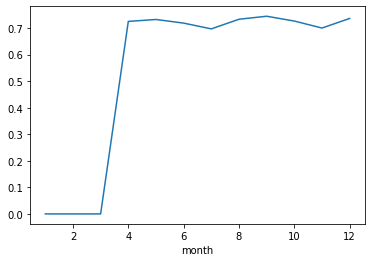

In [28]:
tweets.groupby('month')['correct_label'].mean().plot()

## Online Learning

In [29]:
training_tweets = tweets['2020-04']

tweet_dataset = Dataset.from_pandas(training_tweets.reset_index()[['text', 'label']])
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Update the training arguments and trainer arguments

training_args = TrainingArguments(
    output_dir='./drift_clf/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./drift_clf/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

# Define the trainer
trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics
)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_8923/958100793.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  training_tweets = tweets['2020-04']


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Ignored unknown kwarg option direction


  0%|          | 0/1 [00:00<?, ?it/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


  0%|          | 0/1 [00:00<?, ?it/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Ignored unknown kwarg option direction


In [30]:
Softmax(dim=1)(sequence_classification_model(
    bert_tokenizer.encode(clean_tweet('Corona Virus sucks so bad'), return_tensors='pt')).logits)

tensor([[0.8494, 0.0543, 0.0964]], grad_fn=<SoftmaxBackward0>)

In [31]:
# evaluate on the new data
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 176
  Batch size = 32


{'eval_loss': 0.6205384731292725,
 'eval_accuracy': 0.7215909090909091,
 'eval_runtime': 1.4286,
 'eval_samples_per_second': 123.199,
 'eval_steps_per_second': 4.2}

## Train our DistilBERT model on tweets in April only

In [32]:
trainer.train()

/opt/homebrew/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 703
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Epoch,Training Loss,Validation Loss,Accuracy
1,0.704600,0.558317,0.801136
2,0.429300,0.528065,0.767045


***** Running Evaluation *****
  Num examples = 176
  Batch size = 32
Saving model checkpoint to ./drift_clf/results/checkpoint-22
Configuration saved in ./drift_clf/results/checkpoint-22/config.json
Model weights saved in ./drift_clf/results/checkpoint-22/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 176
  Batch size = 32
Saving model checkpoint to ./drift_clf/results/checkpoint-44
Configuration saved in ./drift_clf/results/checkpoint-44/config.json
Model weights saved in ./drift_clf/results/checkpoint-44/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./drift_clf/results/checkpoint-44 (score: 0.5280651450157166).


TrainOutput(global_step=44, training_loss=0.566939115524292, metrics={'train_runtime': 56.2461, 'train_samples_per_second': 24.997, 'train_steps_per_second': 0.782, 'total_flos': 20371365437472.0, 'train_loss': 0.566939115524292, 'epoch': 2.0})

In [33]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 176
  Batch size = 32


{'eval_loss': 0.5280651450157166,
 'eval_accuracy': 0.7670454545454546,
 'eval_runtime': 2.0057,
 'eval_samples_per_second': 87.749,
 'eval_steps_per_second': 2.991,
 'epoch': 2.0}

In [34]:
Softmax(dim=1)(sequence_classification_model(
    bert_tokenizer.encode(clean_tweet('Corona Virus sucks so bad'), return_tensors='pt')).logits)

tensor([[0.8946, 0.0328, 0.0727]], grad_fn=<SoftmaxBackward0>)

In [35]:
may_onwards = tweets.loc['2020-5':].reset_index()

may_onwards = Dataset.from_pandas(may_onwards[['text', 'label']])

# We will pad our dataset so that our input matrices are the same length and truncate
def preprocess(data):
    return bert_tokenizer(data['text'], padding=True, truncation=True, max_length=128)

may_onwards = may_onwards.map(preprocess, batched=True, batch_size=len(may_onwards))

may_onwards.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

tweets['predicted_label_trained_at_4'] = None
tweets.loc['2020-5':, 'predicted_label_trained_at_4'] = trainer.predict(may_onwards).predictions.argmax(1)

Ignored unknown kwarg option direction


  0%|          | 0/1 [00:00<?, ?it/s]

Ignored unknown kwarg option direction


***** Running Prediction *****
  Num examples = 3806
  Batch size = 32


<AxesSubplot:xlabel='month'>

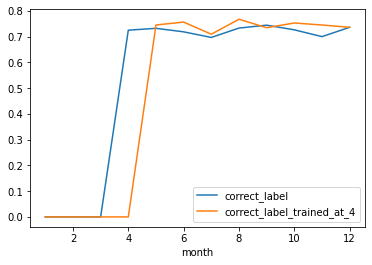

In [37]:
tweets['correct_label_trained_at_4'] = tweets['predicted_label_trained_at_4'] == tweets['label']

tweets.groupby('month')[['correct_label', 'correct_label_trained_at_4']].mean().plot()

In [38]:
training_tweets = tweets['2020-05']

tweet_dataset = Dataset.from_pandas(training_tweets.reset_index()[['text', 'label']])
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)
train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

training_args = TrainingArguments(
    output_dir='./drift_clf/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./drift_clf/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)

# Define the trainer
trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics
)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_8923/992910795.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  training_tweets = tweets['2020-05']


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Ignored unknown kwarg option direction


  0%|          | 0/1 [00:00<?, ?it/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


  0%|          | 0/1 [00:00<?, ?it/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Ignored unknown kwarg option direction


In [39]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 78
  Batch size = 32


{'eval_loss': 0.7994105815887451,
 'eval_accuracy': 0.6923076923076923,
 'eval_runtime': 0.6514,
 'eval_samples_per_second': 119.74,
 'eval_steps_per_second': 4.605}

## Train our DistilBERT model on tweets in May only

In [40]:
trainer.train()

/opt/homebrew/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 310
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Epoch,Training Loss,Validation Loss,Accuracy
1,0.660400,0.786373,0.705128
2,0.404800,0.781244,0.641026


***** Running Evaluation *****
  Num examples = 78
  Batch size = 32
Saving model checkpoint to ./drift_clf/results/checkpoint-10
Configuration saved in ./drift_clf/results/checkpoint-10/config.json
Model weights saved in ./drift_clf/results/checkpoint-10/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 78
  Batch size = 32
Saving model checkpoint to ./drift_clf/results/checkpoint-20
Configuration saved in ./drift_clf/results/checkpoint-20/config.json
Model weights saved in ./drift_clf/results/checkpoint-20/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./drift_clf/results/checkpoint-20 (score: 0.7812435626983643).


TrainOutput(global_step=20, training_loss=0.5325803995132447, metrics={'train_runtime': 25.9516, 'train_samples_per_second': 23.891, 'train_steps_per_second': 0.771, 'total_flos': 11228882086800.0, 'train_loss': 0.5325803995132447, 'epoch': 2.0})

In [41]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 78
  Batch size = 32


{'eval_loss': 0.7812435626983643,
 'eval_accuracy': 0.6410256410256411,
 'eval_runtime': 1.2123,
 'eval_samples_per_second': 64.338,
 'eval_steps_per_second': 2.475,
 'epoch': 2.0}

In [42]:
Softmax(dim=1)(sequence_classification_model(
    bert_tokenizer.encode(clean_tweet('Corona Virus sucks so bad'), return_tensors='pt')).logits)

tensor([[0.9001, 0.0418, 0.0581]], grad_fn=<SoftmaxBackward0>)

In [43]:
june_onwards = tweets.loc['2020-6':].reset_index()


june_onwards = Dataset.from_pandas(june_onwards[['text', 'label']])

# We will pad our dataset so that our input matrices are the same length and truncate
def preprocess(data):
    return bert_tokenizer(data['text'], padding=True, truncation=True, max_length=128)

june_onwards = june_onwards.map(preprocess, batched=True, batch_size=len(june_onwards))

june_onwards.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

tweets['predicted_label_trained_at_5'] = None
tweets.loc['2020-6':, 'predicted_label_trained_at_5'] = trainer.predict(june_onwards).predictions.argmax(1)

Ignored unknown kwarg option direction


  0%|          | 0/1 [00:00<?, ?it/s]

Ignored unknown kwarg option direction


***** Running Prediction *****
  Num examples = 3418
  Batch size = 32


<AxesSubplot:xlabel='month'>

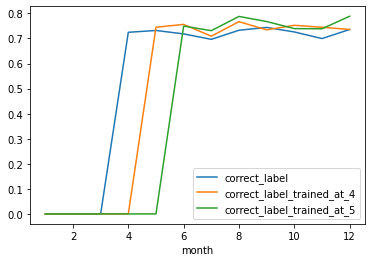

In [44]:
# Online training will generally only close minor gaps in performance and usually is not enough
tweets['correct_label_trained_at_5'] = tweets['predicted_label_trained_at_5'] == tweets['label']
tweets.groupby('month')[['correct_label', 'correct_label_trained_at_4', 'correct_label_trained_at_5']].mean().plot()

**Kullback–Leibler (KL) divergence** is a measure of difference between two probability distributions. It is unbounded and assymetric (top is continuous, bottom is discrete)
![title](../images/kl1.png)
![title](../images/kl2.png)

**Jensen-Shannon (or JS) divergence** is another way to test differences between distributions based on the KL divergence. It symmetric and it always has a finite value.
![title](../images/js.png)


In [45]:
def kl_divergence(p, q):
    '''Kullback–Leibler (KL) divergence'''
    p /= p.mean()
    q /= q.mean()
    return np.sum(p*np.log((p/(q+ 1e-5)) + 1e-5))


def js_divergence(p, q):
    '''Jensen-Shannon (or JS) divergence'''
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

## KL Divergenve

In [46]:
# Calculate accuracy change by month
monthly_stats = tweets.groupby('month').agg(accuracy=('correct_label', 'mean'))
monthly_stats['accuracy_change'] = (monthly_stats['accuracy'] - monthly_stats['accuracy'].shift(1)) / monthly_stats['accuracy'].shift(1)
monthly_stats


,accuracy,accuracy_change
month,,
1,0.000000,NaN
2,0.000000,NaN
3,0.000000,NaN
4,0.724687,inf
5,0.731959,0.010034
6,0.718287,-0.018679
7,0.696541,-0.030275
8,0.732836,0.052107
9,0.744141,0.015426


In [47]:
kl_change = [0, 0, 0, 0]  # for months 1, 2, 3, and 4
js_change = [0, 0, 0, 0]  # for months 1, 2, 3, and 4

# Calculate divergence
for month in range(4, 12):
    kl_div = kl_divergence(
        tweets[tweets.index.month==month]['predicted_label'].value_counts(normalize=True).sort_index(),
        tweets[tweets.index.month==month + 1]['predicted_label'].value_counts(normalize=True).sort_index()
    )
    js_div = js_divergence(
        tweets[tweets.index.month==month]['predicted_label'].value_counts(normalize=True).sort_index(),
        tweets[tweets.index.month==month + 1]['predicted_label'].value_counts(normalize=True).sort_index()
    )
    js_change.append(js_div)
    kl_change.append(kl_div)
monthly_stats['kl'] = kl_change
monthly_stats['js'] = js_change

monthly_stats

,accuracy,accuracy_change,kl,js
month,,,,
1,0.000000,NaN,0.000000,0.000000
2,0.000000,NaN,0.000000,0.000000
3,0.000000,NaN,0.000000,0.000000
4,0.724687,inf,0.000000,0.000000
5,0.731959,0.010034,0.001378,0.000344
6,0.718287,-0.018679,0.012928,0.003238
7,0.696541,-0.030275,0.018373,0.004653
8,0.732836,0.052107,0.008648,0.002159
9,0.744141,0.015426,0.012198,0.003029


<AxesSubplot:title={'center':'Plotting Divergence with Accuracy % Change'}, xlabel='month'>

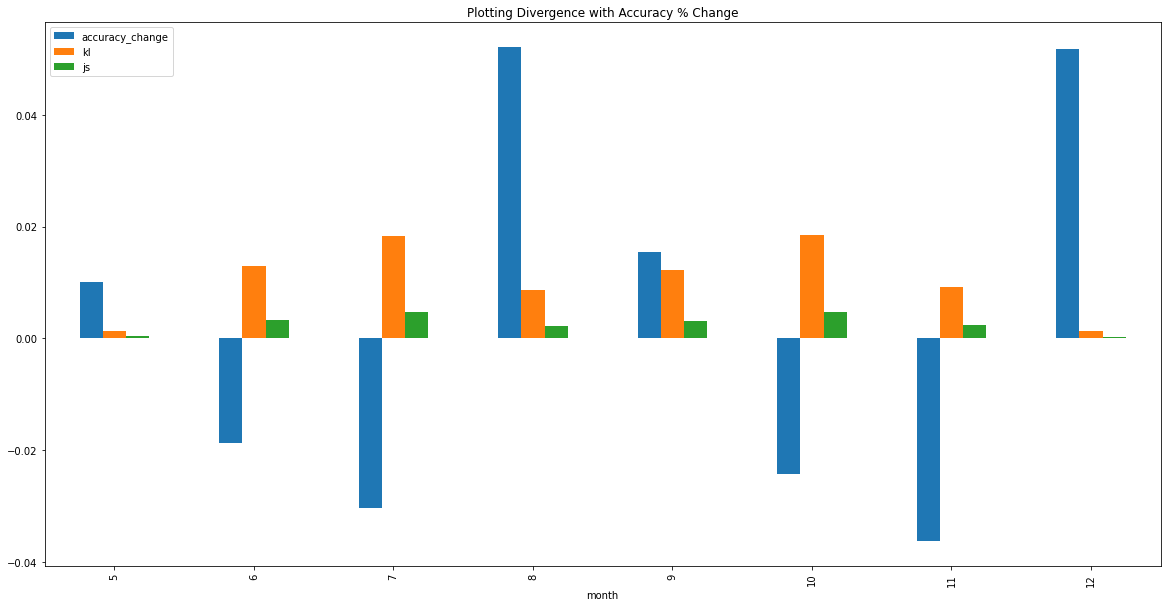

In [48]:
monthly_stats[monthly_stats.index >= 5][['accuracy_change', 'kl', 'js']].plot(
    kind='bar', figsize=(20, 10), title='Plotting Divergence with Accuracy % Change'
)